## Домашняя работа #4.

Домашнее задание сдаётся в виде ссылки (с доступом комментатор или редактор) на Colab в опросе.

Отправлять ссылку через форму нужно только один раз. Исправления вносятся в тот же ноутбук до хард-дедлайна и помечаются комментариями в коде и комментариями к соотвествующим ячейкам.


Домашка на использование параметрических моделей.
* Ransac.
* Hough transform.


**Soft deadline: 25.04.2023 03:00:00 +0003 GMT**

**Hard deadline: 02.05.2023 03:00:00 +0003 GMT**

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import imutils
cv2.ocl.setUseOpenCL(False)

from collections import defaultdict
from tqdm.auto import tqdm
import time

# RANSAC

Ниже приведены блоки кода с помощью которых можно склеивать панорамы в единую картинку.
* Извлекаем ключевые точки
* Сопоставляем похожие
* Ищем гомографию
* Склеиваем изображения

Гомография это обычное преобразование одник координат к другим с помощью матрицы. Мы должны с помощью `RANSAC` найти параметры этой матрицы.
Для этого вы случайно берете `s` точек, по ним оцениваете значения $h_{11}$, .., $h_{33}$ считаете значние ошибки сопоставления на всех точках, etc

# Скачиваем картинки

In [17]:
# select the image id (valid values 1,2,3, or 4)
feature_extractor = 'orb' # one of 'sift', 'surf', 'brisk', 'orb'
feature_matching = 'bf'

<ipython-input-18-b05913bc9093>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  trainImg = imageio.imread('http://www.ic.unicamp.br/~helio/imagens_registro/foto1A.jpg')
<ipython-input-18-b05913bc9093>:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  queryImg = imageio.imread('http://www.ic.unicamp.br/~helio/imagens_registro/foto1B.jpg')


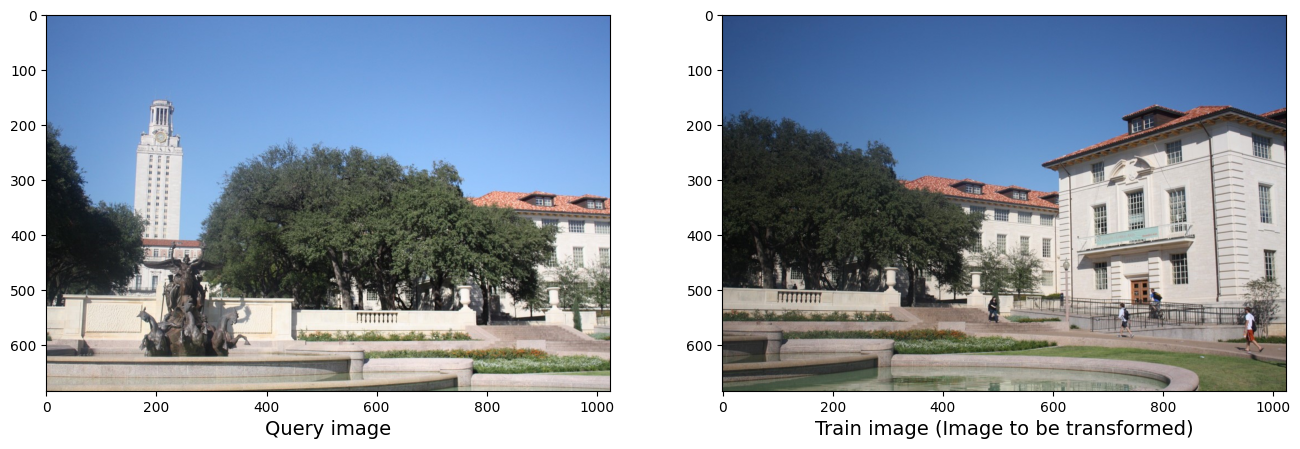

In [18]:
trainImg = imageio.imread('http://www.ic.unicamp.br/~helio/imagens_registro/foto1A.jpg')
trainImg_gray = cv2.cvtColor(trainImg, cv2.COLOR_RGB2GRAY)

queryImg = imageio.imread('http://www.ic.unicamp.br/~helio/imagens_registro/foto1B.jpg')
# Opencv defines the color channel in the order BGR.
# Transform it to RGB to be compatible to matplotlib
queryImg_gray = cv2.cvtColor(queryImg, cv2.COLOR_RGB2GRAY)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(queryImg, cmap="gray")
ax1.set_xlabel("Query image", fontsize=14)

ax2.imshow(trainImg, cmap="gray")
ax2.set_xlabel("Train image (Image to be transformed)", fontsize=14)

plt.show()

# Ищем ключевые точки и вычисляем дексрипторы

In [19]:
def detectAndDescribe(image, method=None):
    """
    Compute key points and feature descriptors using an specific method
    """

    assert method is not None, "You need to define a feature detection method. Values are: 'sift', 'surf'"

    # detect and extract features from the image
    if method == 'sift':
        descriptor = cv2.xfeatures2d.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.xfeatures2d.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()

    # get keypoints and descriptors
    (kps, features) = descriptor.detectAndCompute(image, None)

    return (kps, features)

In [20]:
kpsA, featuresA = detectAndDescribe(trainImg_gray, method=feature_extractor)
kpsB, featuresB = detectAndDescribe(queryImg_gray, method=feature_extractor)

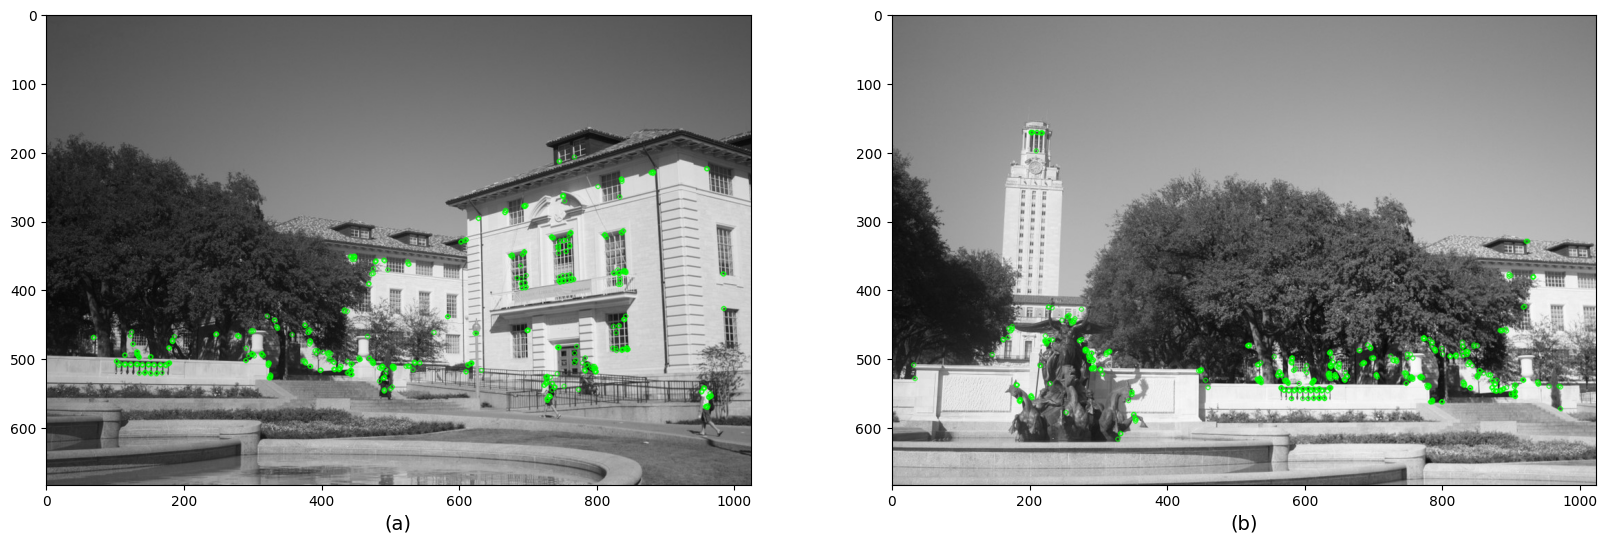

In [21]:
# display the keypoints and features detected on both images
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(trainImg_gray,kpsA,None,color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(queryImg_gray,kpsB,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)

plt.show()

# Ищем похожие дескрипторы

In [22]:
def createMatcher(method,crossCheck):
    "Create and return a Matcher Object"

    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

In [23]:
def matchKeyPointsBF(featuresA, featuresB, method):
    bf = createMatcher(method, crossCheck=True)

    # Match descriptors.
    best_matches = bf.match(featuresA,featuresB)

    # Sort the features in order of distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches (Brute force):", len(rawMatches))
    return rawMatches

In [24]:
def matchKeyPointsKNN(featuresA, featuresB, ratio, method):
    bf = createMatcher(method, crossCheck=False)
    # compute the raw matches and initialize the list of actual matches
    rawMatches = bf.knnMatch(featuresA, featuresB, 2)
    print("Raw matches (knn):", len(rawMatches))
    matches = []

    # loop over the raw matches
    for m,n in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

Using: bf feature matcher
Raw matches (Brute force): 189


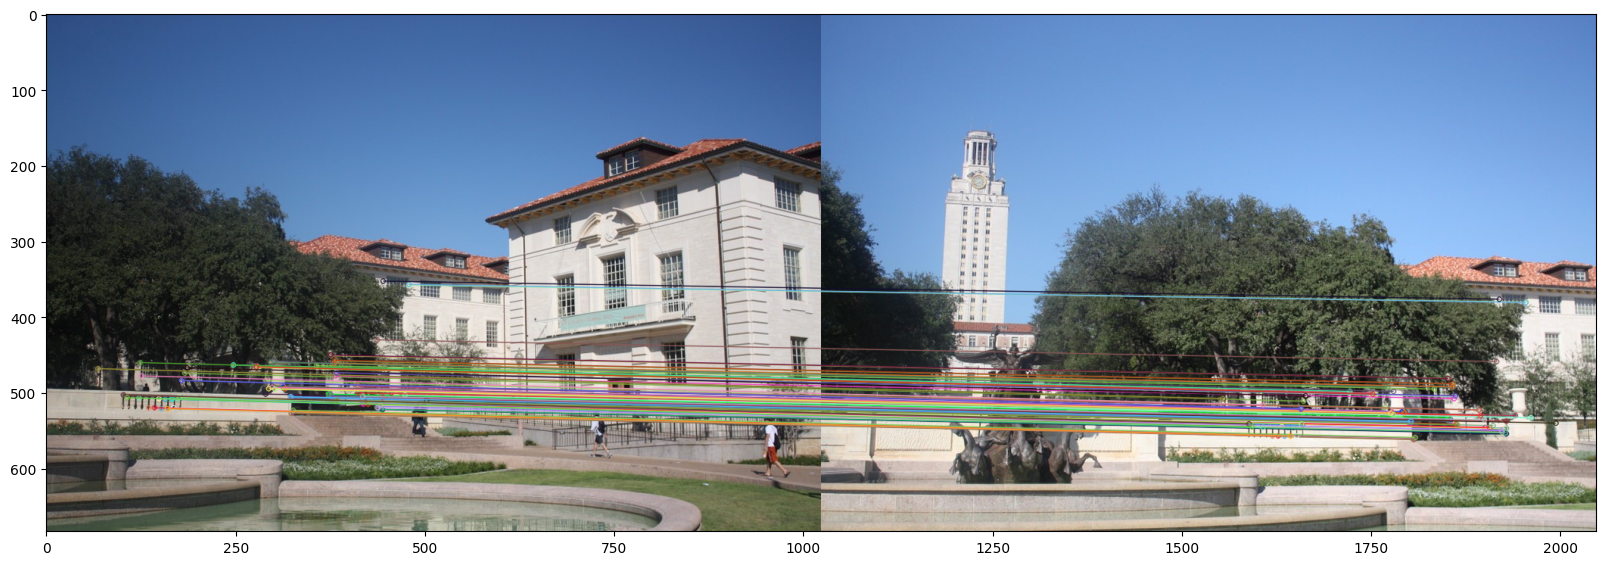

In [25]:
print("Using: {} feature matcher".format(feature_matching))

fig = plt.figure(figsize=(20,8))

if feature_matching == 'bf':
    matches = matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
elif feature_matching == 'knn':
    matches = matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,np.random.choice(matches,100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)


plt.imshow(img3)
plt.show()

# Сопоставление ключевых точек на изображении

In [26]:
def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])

    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])

        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
            reprojThresh)

        return (matches, H, status)
    else:
        return None

In [27]:
M = getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh=4)
if M is None:
    print("Error!")
(matches, H, status) = M
print(H)

[[ 7.40803245e-01 -4.99883247e-02  4.60620696e+02]
 [-1.15882069e-01  7.98230472e-01  1.00867120e+02]
 [-1.78934909e-04 -1.49752313e-04  1.00000000e+00]]


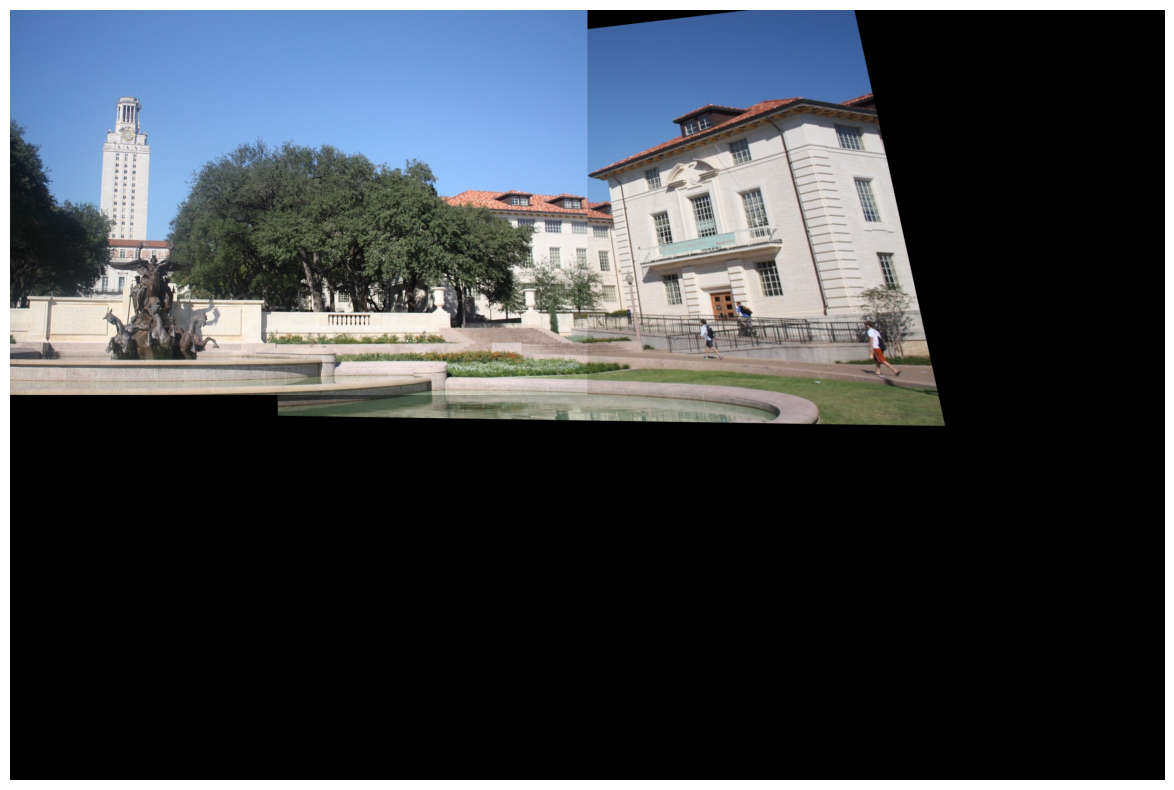

In [28]:
# Apply panorama correction
width = trainImg.shape[1] + queryImg.shape[1]
height = trainImg.shape[0] + queryImg.shape[0]

result = cv2.warpPerspective(trainImg, H, (width, height))
result[0:queryImg.shape[0], 0:queryImg.shape[1]] = queryImg

plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()

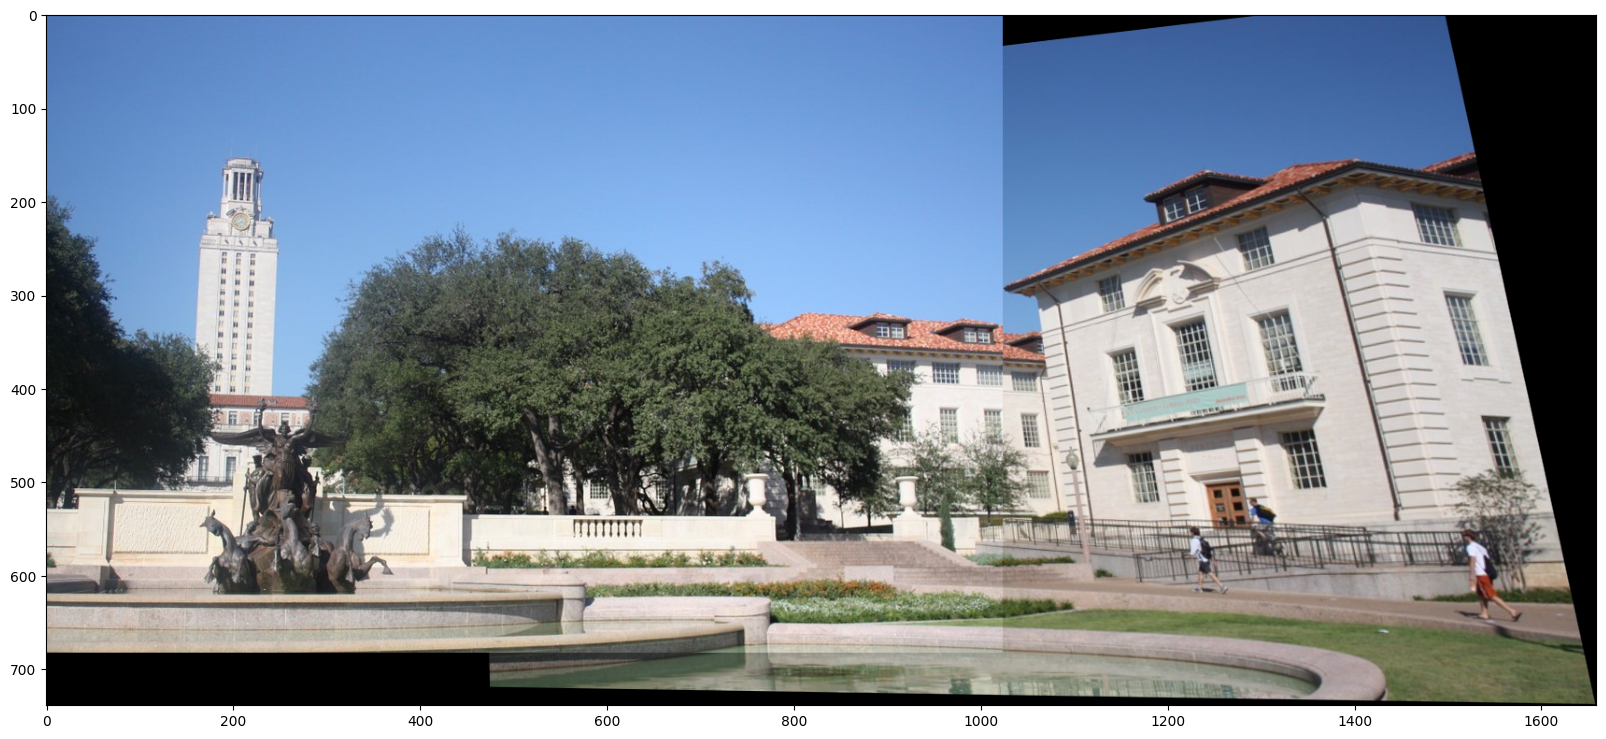

In [14]:
# transform the panorama image to grayscale and threshold it
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

# Finds contours from the binary image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# get the maximum contour area
c = max(cnts, key=cv2.contourArea)

# get a bbox from the contour area
(x, y, w, h) = cv2.boundingRect(c)

# crop the image to the bbox coordinates
result = result[y:y + h, x:x + w]

# show the cropped image
plt.figure(figsize=(20,10))
plt.imshow(result)

**Задание 1. (20 баллов)**

Напишите свою функцию `findHomography` , которая принмает на вход список сопоставленных точек и использует `RANSAC` для определния матрицы гомографии. Примените вашу функцию и сравните результат. Склейте панораму используя матрицу гомографии. `RANSAC` тоже нужно имплементировать самостоятельно.

In [29]:
# функция для подсчета расстояния
def calc_distance(points, H):
    point1, point2 = np.array([points[0], points[1], 1]), np.array([points[2], points[3], 1])
    point2_e = np.dot(H, point1.T)
    point2_e = (1 / point2_e[2]) * point2_e
    res = np.linalg.norm(point2.T - point2_e)
    return res

# функция для расчета гомографии
def calc_homography(points):
    A = []
    for x, y, x_p, y_p in points:
        A.append([x, y, 1, 0, 0, 0, -x_p * x, -x_p * y, -x_p])
        A.append([0, 0, 0, x, y, 1, -y_p * x, -y_p * y, -y_p])
    U, S, V = np.linalg.svd(np.array(A))
    H = np.reshape(V[-1], (3, 3))
    H = (1 / H.item(8)) * H
    return H

# RANSAC
def findHomography(points_list, thresh = 0.6):
    Final_H = None
    Final_Inliers = set()
    for i in range(100):
        points = [points_list[i] for i in np.random.choice(len(points_list), 4)]
        H = calc_homography(points)
        for j in range(len(points_list)):
            inliers = {(p[0], p[1], p[2], p[3]) for p in points_list if calc_distance(p, H) < 8}
            if len(inliers) > len(Final_Inliers):
                Final_Inliers = inliers
                Final_H = H
                if len(Final_Inliers) > (len(points_list) * thresh):
                    break

    return Final_H


In [30]:
kpsA, featuresA = detectAndDescribe(trainImg_gray, method=feature_extractor)
kpsB, featuresB = detectAndDescribe(queryImg_gray, method=feature_extractor)

kpsA = np.float32([kp.pt for kp in kpsA])
kpsB = np.float32([kp.pt for kp in kpsB])

if len(matches) > 4:
    ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
    ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
    points_list = np.concatenate((ptsA, ptsB), axis = 1)
    # подаю на вход список сопоставленных точек
    H = findHomography(points_list)
print(H)

[[ 4.18715443e-01 -5.14973736e-01  5.96696169e+02]
 [-1.59525381e-01  3.31754947e-01  2.13163790e+02]
 [-2.64946978e-04 -6.00555115e-04  1.00000000e+00]]


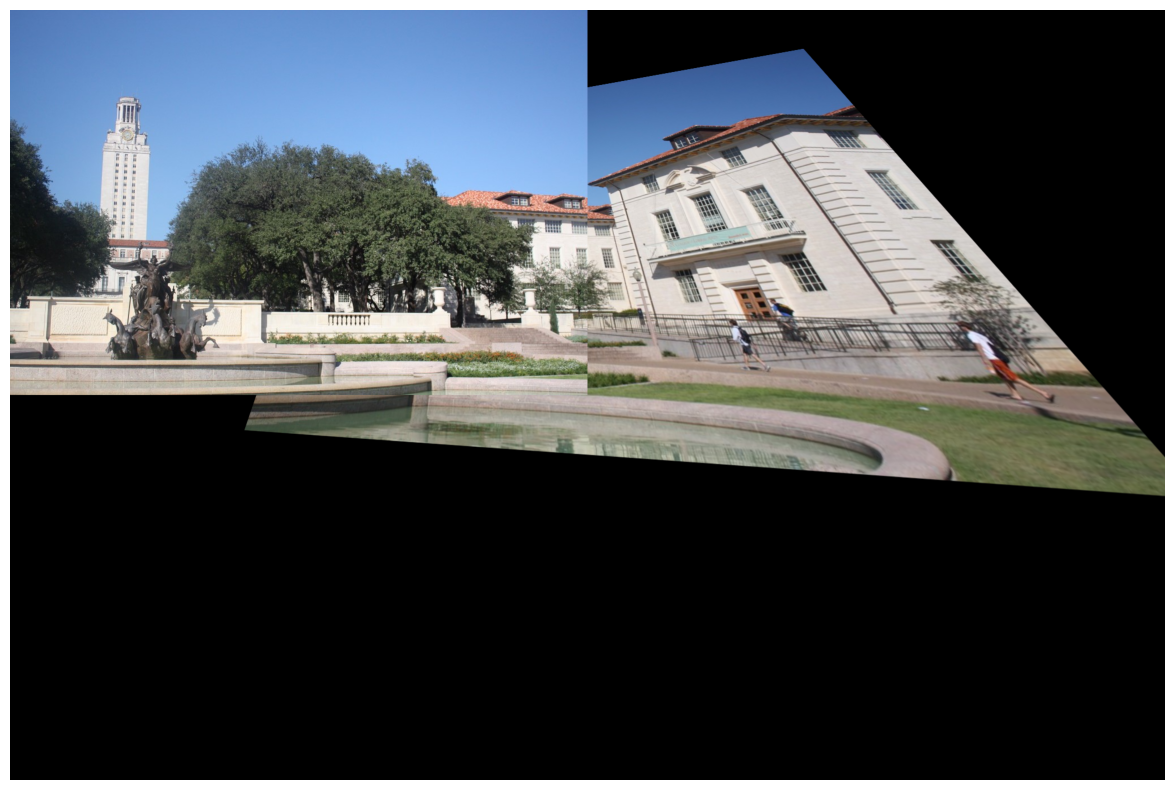

In [31]:
# Apply panorama correction
width = trainImg.shape[1] + queryImg.shape[1]
height = trainImg.shape[0] + queryImg.shape[0]

result = cv2.warpPerspective(trainImg, H, (width, height))
result[0:queryImg.shape[0], 0:queryImg.shape[1]] = queryImg

plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()

**Задание 2. (10 баллов)**

Напишите преобразование Хафа для поиска окружностей. Если для прямых мы делали трюк с превращением одного из параметров в cos для того, чтобы он был ограничен, то тут, кажется, нам надо перебрать координаты и всевозможные радиусы.  Примените его для поиска окружнойтей на изображении *сoins_noize_1.jpg* из предыдущего домашнего задания. Если не хотите перебирать руками все радиусы, то можно попробовать вдохновиться [этой работой](https://www.ecse.rpi.edu/~cvrl/Publication/pdf/Xie2002.pdf)

Сравните вашу функцию с функцией `cv.HoughCircles` по времени работы и по качеству.

In [34]:
coins = cv2.imread('coins_noize_1.jpg')

In [35]:
def find_edges(img, threshold1=100, threshold2=100):
  filtered_img = cv2.medianBlur(img, 13)
  img_gray = cv2.cvtColor(filtered_img, cv2.COLOR_BGR2GRAY)
  canny = cv2.Canny(img_gray, threshold1, threshold2)
  coords = []
  for i in range(canny.shape[1]):
    for j in range(canny.shape[0]):
      if canny[j, i] == 255:
        coords.append((i, j))
  return coords

In [36]:
def houghCircles(img, min_dist=20, threshold1=50, threshold2=100, r_min=25, r_max=50, theta_num=20, threshold=0.4):

  coords = find_edges(img, threshold1, threshold2)
  height, width = img.shape[:2]

  # Our parameters
  thetas = np.linspace(0, 2*np.pi, theta_num)
  rs = np.arange(r_min, r_max)
  cos_theta, sin_theta = np.cos(thetas), np.sin(thetas)

  A = defaultdict(int)

  for x, y in coords:
    for r in rs:
      for i in range(theta_num):
        a = int(x - r * cos_theta[i])
        b = int(y - r * sin_theta[i])
        A[(a, b, r)] += 1

  result = []
  for circle, cnt in A.items():
      d = cnt / theta_num
      if d >= threshold:
        result.append(circle)

  circles = []
  for x1, y1, r1 in result:
     if all(abs(x1 - x2) > min_dist or abs(y1 - y2) > min_dist for x2, y2, r2 in circles):
        circles.append((x1, y1, r1))

  img_copy = img.copy()
  img_copy = cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)
  for x, y, r in circles:
    img_copy = cv2.circle(img_copy, (x, y), int(r), (0, 0, 255), 2)

  plt.imshow(img_copy)
  plt.axis('off')

Execution time: 19.57 seconds


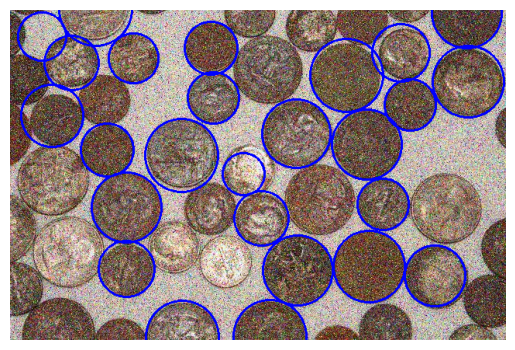

In [37]:
start_time = time.time()
houghCircles(coins)
print(f"Execution time: {round(time.time() - start_time, 2)} seconds")

Execution time: 0.06 seconds


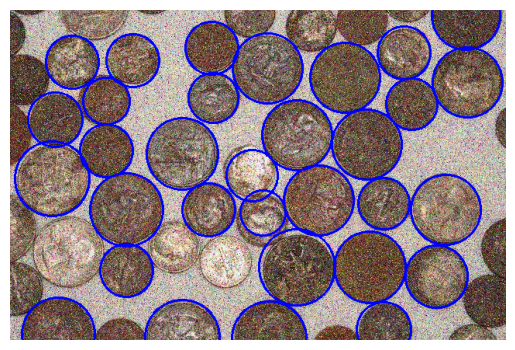

In [39]:
# Сравнение с cv2.HoughCircles
start_time = time.time()

cimg = np.copy(cv2.cvtColor(coins, cv2.COLOR_BGR2RGB))
img = cv2.cvtColor(coins, cv2.COLOR_BGR2GRAY)
img = cv2.medianBlur(img, 13)
res = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,20,param1=100,param2=15,minRadius=25,maxRadius=50)

if res is not None:
	  circles = np.round(res[0, :]).astype("int")
	  for (x, y, r) in circles:
		  cv2.circle(cimg, (x, y), r, (0, 0, 255), 2)

plt.imshow(cimg)
plt.axis('off')

print(f"Execution time: {round(time.time() - start_time, 2)} seconds")

Итог: функция из библиотеки работает значительно быстрее, по качеству лучше - находит больше кружочков при аналогичных параметрах